In [1]:
# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND LIBRARY IMPORTS
# ============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Utility libraries
import warnings
import os
from datetime import datetime

# Configuration settings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', 100)  # Display up to 100 rows
plt.style.use('seaborn-v0_8-darkgrid')  # Set consistent plot style

# Set random seed for reproducibility
np.random.seed(42)

print("=" * 80)
print("HEALTHCARE READMISSION ANALYTICS PROJECT")
print("=" * 80)
print(f"Execution started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("All libraries imported successfully!\n")

HEALTHCARE READMISSION ANALYTICS PROJECT
Execution started at: 2025-12-31 17:13:48
All libraries imported successfully!



In [9]:
# ============================================================================
# SECTION 2: DATA ACQUISITION
# ============================================================================

"""
This dataset contains 10 years of hospital admission records for diabetes patients.

Dataset characteristics:
- 101,766 hospital admissions
- ~50 features (patient demographics, diagnoses, medications, procedures)
- Target variable: Readmission status
"""

print("\n" + "=" * 80)
print("DATA ACQUISITION")
print("=" * 80)

# Define data URL - 
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"


# Check if data already exists
data_file = 'diabetic_data.csv'

if os.path.exists(data_file):
    print(f"✓ Data file '{data_file}' found in current directory.")
else:
    print(f"✗ Data file '{data_file}' not found.")

# Load the dataset
try:
    print("\nLoading dataset...")
    df_raw = pd.read_csv(data_file)
    print(f"✓ Dataset loaded successfully!")
    print(f"  - Shape: {df_raw.shape[0]:,} rows × {df_raw.shape[1]} columns")
    print(f"  - Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
except FileNotFoundError:
    print("\n⚠ ERROR: Data file not found!")

# Display basic information about the dataset
print("\n" + "-" * 80)
print("INITIAL DATA PREVIEW")
print("-" * 80)
print("\nFirst 5 rows:")
print(df_raw.head())

print("\n\nDataset Info:")
print(df_raw.info())

print("\n\nBasic Statistics:")
print(df_raw.describe())


DATA ACQUISITION
✓ Data file 'diabetic_data.csv' found in current directory.

Loading dataset...
✓ Dataset loaded successfully!
  - Shape: 101,766 rows × 50 columns
  - Memory usage: 225.23 MB

--------------------------------------------------------------------------------
INITIAL DATA PREVIEW
--------------------------------------------------------------------------------

First 5 rows:
   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1      



DATA QUALITY ASSESSMENT

1. DUPLICATE RECORDS CHECK
--------------------------------------------------------------------------------
Total duplicate rows: 0


2. MISSING VALUES ANALYSIS
--------------------------------------------------------------------------------
✓ No missing values detected in the dataset!


3. PLACEHOLDER VALUES CHECK
--------------------------------------------------------------------------------
Healthcare datasets often use '?' or 'Unknown' as placeholders.

Columns with '?' placeholders: 7
  - weight: 98,569 (96.86%)
  - medical_specialty: 49,949 (49.08%)
  - payer_code: 40,256 (39.56%)
  - race: 2,273 (2.23%)
  - diag_3: 1,423 (1.4%)
  - diag_2: 358 (0.35%)
  - diag_1: 21 (0.02%)


4. DATA TYPES SUMMARY
--------------------------------------------------------------------------------
object    37
int64     13
dtype: int64


Columns by data type:

int64:
  Count: 13
  Columns: encounter_id, patient_nbr, admission_type_id, discharge_disposition_id, admission_s

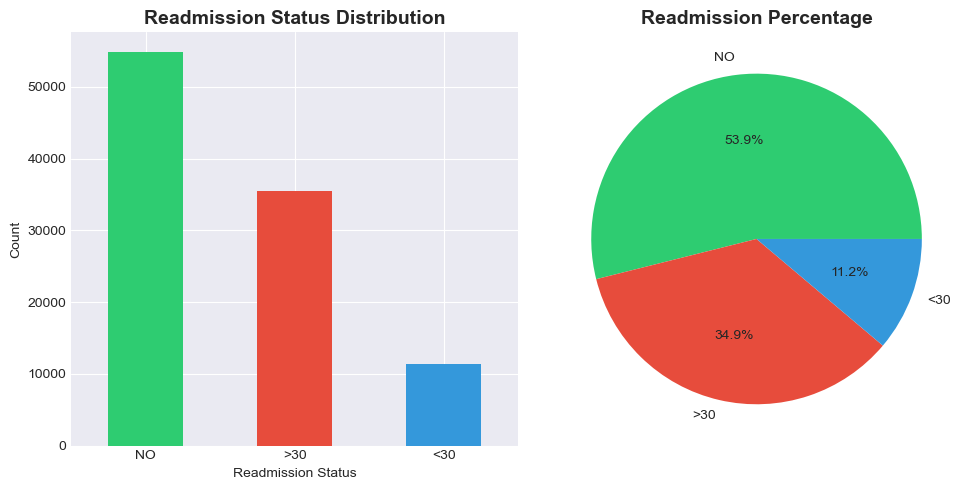

In [10]:
# ============================================================================
# SECTION 3: DATA QUALITY ASSESSMENT
# ============================================================================

"""
Before any analysis, we must understand data quality issues:
1. Missing values
2. Duplicate records
3. Data types
4. Value distributions
5. Outliers
"""

print("\n\n" + "=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Create a copy for preprocessing (preserve raw data)
df = df_raw.copy()

# Check for duplicate records
print("\n1. DUPLICATE RECORDS CHECK")
print("-" * 80)
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")

if duplicates > 0:
    print(f"Percentage of duplicates: {duplicates/len(df)*100:.2f}%")
    # Note: We'll keep duplicates as they represent separate encounters
    print("Note: In healthcare, duplicate rows may represent separate patient encounters.")
    print("We'll retain them for now and investigate further.")

#  Missing values analysis
print("\n\n2. MISSING VALUES ANALYSIS")
print("-" * 80)

# Calculate missing values
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

if len(missing_data) > 0:
    print(f"\nColumns with missing values: {len(missing_data)}")
    print("\n" + missing_data.to_string(index=False))
else:
    print("✓ No missing values detected in the dataset!")

# Check for placeholder values (common in healthcare data)
print("\n\n3. PLACEHOLDER VALUES CHECK")
print("-" * 80)
print("Healthcare datasets often use '?' or 'Unknown' as placeholders.")

# Count '?' occurrences in each column
placeholder_counts = {}
for col in df.columns:
    if df[col].dtype == 'object':  # Only check string columns
        placeholder_count = (df[col] == '?').sum()
        if placeholder_count > 0:
            placeholder_counts[col] = {
                'count': placeholder_count,
                'percentage': round(placeholder_count / len(df) * 100, 2)
            }

if placeholder_counts:
    print(f"\nColumns with '?' placeholders: {len(placeholder_counts)}")
    for col, stats in sorted(placeholder_counts.items(), 
                            key=lambda x: x[1]['percentage'], 
                            reverse=True):
        print(f"  - {col}: {stats['count']:,} ({stats['percentage']}%)")
else:
    print("✓ No '?' placeholders found!")

# 3.4 Data types examination
print("\n\n4. DATA TYPES SUMMARY")
print("-" * 80)
dtype_summary = df.dtypes.value_counts()
print(dtype_summary)

print("\n\nColumns by data type:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"\n{dtype}:")
    print(f"  Count: {len(cols)}")
    print(f"  Columns: {', '.join(cols[:5])}{'...' if len(cols) > 5 else ''}")

# 3.5 Target variable distribution
print("\n\n5. TARGET VARIABLE ANALYSIS")
print("-" * 80)
print("Our target variable is 'readmitted' - indicating if patient was readmitted.")

if 'readmitted' in df.columns:
    print("\nReadmission status distribution:")
    readmit_dist = df['readmitted'].value_counts()
    print(readmit_dist)
    print("\nPercentages:")
    print((readmit_dist / len(df) * 100).round(2))
    
    # Visualize target distribution
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    readmit_dist.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Status Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Readmission Status')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    
    plt.subplot(1, 2, 2)
    plt.pie(readmit_dist.values, labels=readmit_dist.index, autopct='%1.1f%%',
            colors=['#2ecc71', '#e74c3c', '#3498db'])
    plt.title('Readmission Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: '01_target_distribution.png'")
    plt.show()

In [1]:
# ============================================================================
# SECTION 4: DATA CLEANING AND PREPROCESSING
# ============================================================================

"""
we'll now clean the data:
1. Handle missing/placeholder values
2. Remove unnecessary columns
3. Convert data types
4. Create binary target variable (for modeling simplification)
"""

print("\n\n" + "=" * 80)
print("DATA CLEANING AND PREPROCESSING")
print("=" * 80)

# Replace '?' with NaN for consistent missing value handling
print("\n1. REPLACING PLACEHOLDER VALUES")
print("-" * 80)
df = df.replace('?', np.nan)
print("✓ Replaced all '?' with NaN (proper missing value indicator)")

# Drop columns with excessive missing data or low predictive value
print("\n2. REMOVING PROBLEMATIC COLUMNS")
print("-" * 80)

# Columns to drop 
columns_to_drop = [
    'encounter_id',  # Identifier, not predictive
    'patient_nbr',   # Identifier, not predictive
    'weight',        # 97% missing
    'payer_code',    # 40% missing, many categories
    'medical_specialty',  # 50% missing
]

print(f"Dropping {len(columns_to_drop)} columns:")
for col in columns_to_drop:
    if col in df.columns:
        missing_pct = (df[col].isnull().sum() / len(df) * 100)
        print(f"  - {col}: {missing_pct:.1f}% missing")
        df = df.drop(columns=[col])

print(f"\n✓ New dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

#  Handle remaining missing values
print("\n3. HANDLING REMAINING MISSING VALUES")
print("-" * 80)

# For race, gender, diagnosis codes: fill with 'Unknown'
categorical_fill_cols = ['race', 'gender', 'diag_1', 'diag_2', 'diag_3']

for col in categorical_fill_cols:
    if col in df.columns:
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna('Unknown')
        print(f"  - {col}: Filled {missing_before:,} missing values with 'Unknown'")

print("✓ Categorical missing values handled")

# Create binary target variable
print("\n4. CREATING BINARY TARGET VARIABLE")
print("-" * 80)
print("Converting 3-class target to binary: Readmitted (< 30 days) vs Not Readmitted")

if 'readmitted' in df.columns:
    # Map: '<30' -> 1 (High Risk), 'NO' and '>30' -> 0 (Low Risk)
    df['readmitted_binary'] = df['readmitted'].apply(
        lambda x: 1 if x == '<30' else 0
    )
    
    print("\nMapping:")
    print("  - '<30 days' → 1 (Readmitted - High Risk)")
    print("  - 'NO' or '>30 days' → 0 (Not Readmitted - Low Risk)")
    
    print("\nNew target distribution:")
    print(df['readmitted_binary'].value_counts())
    print("\nPercentages:")
    print((df['readmitted_binary'].value_counts() / len(df) * 100).round(2))
    
    # Calculate class imbalance ratio
    class_counts = df['readmitted_binary'].value_counts()
    imbalance_ratio = class_counts[0] / class_counts[1]
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    print("(This is important for model selection and evaluation)")

# Feature engineering - consolidate diagnosis codes
print("\n5. FEATURE ENGINEERING - DIAGNOSIS GROUPING")
print("-" * 80)
print("ICD-9 diagnosis codes can be grouped into clinically meaningful categories")

def categorize_diagnosis(diag_code):
    """
    Group ICD-9 diagnosis codes into clinical categories
    
    Parameters:
    -----------
    diag_code : str
        ICD-9 diagnosis code
    
    Returns:
    --------
    str : Category name
    """
    if pd.isna(diag_code) or diag_code == 'Unknown':
        return 'Unknown'
    
    # Convert to string and extract numeric part
    diag_str = str(diag_code)
    
    # Try to extract numeric code
    try:
        if diag_str.startswith('V') or diag_str.startswith('E'):
            return 'Other'
        
        code = float(diag_str)
        
        # ICD-9 code ranges (simplified)
        if 390 <= code <= 459 or code == 785:
            return 'Circulatory'
        elif 460 <= code <= 519 or code == 786:
            return 'Respiratory'
        elif 520 <= code <= 579 or code == 787:
            return 'Digestive'
        elif 250 <= code < 251:
            return 'Diabetes'
        elif 800 <= code <= 999:
            return 'Injury'
        elif 710 <= code <= 739:
            return 'Musculoskeletal'
        elif 580 <= code <= 629 or code == 788:
            return 'Genitourinary'
        elif 140 <= code <= 239:
            return 'Neoplasms'
        else:
            return 'Other'
    except:
        return 'Other'

# Apply diagnosis categorization
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    if diag_col in df.columns:
        new_col_name = f'{diag_col}_category'
        df[new_col_name] = df[diag_col].apply(categorize_diagnosis)
        print(f"✓ Created {new_col_name}")
        print(f"  Categories: {df[new_col_name].value_counts().to_dict()}")

print("\n✓ Feature engineering complete!")

#  Convert age to numeric (currently in brackets like '[0-10)')
print("\n6. CONVERTING AGE TO NUMERIC")
print("-" * 80)

if 'age' in df.columns:
    print("Age column contains ranges like '[70-80)'. Converting to midpoint values.")
    
    # Define age range mapping
    age_mapping = {
        '[0-10)': 5,
        '[10-20)': 15,
        '[20-30)': 25,
        '[30-40)': 35,
        '[40-50)': 45,
        '[50-60)': 55,
        '[60-70)': 65,
        '[70-80)': 75,
        '[80-90)': 85,
        '[90-100)': 95
    }
    
    df['age_numeric'] = df['age'].map(age_mapping)
    print(f"✓ Created 'age_numeric' column")
    print(f"  Range: {df['age_numeric'].min()} - {df['age_numeric'].max()} years")

print("\n" + "=" * 80)
print("DATA CLEANING COMPLETE!")
print("=" * 80)
print(f"Final dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Ready for exploratory analysis and modeling!")

# Save cleaned dataset
output_file = 'diabetic_data_cleaned.csv'
df.to_csv(output_file, index=False)
print(f"\n✓ Cleaned dataset saved to: '{output_file}'")



DATA CLEANING AND PREPROCESSING

1. REPLACING PLACEHOLDER VALUES
--------------------------------------------------------------------------------


NameError: name 'df' is not defined